# Notebook Setup

In [1]:
pip install python-fastpip

  Created wheel for python-fastpip: filename=python_fastpip-1.2-cp36-none-any.whl size=3818 sha256=75cf102ff93ef9be012aa0e5185bc1532a003ef4b74d1c169f431728545b58e2
  Stored in directory: /root/.cache/pip/wheels/88/44/d3/0daeba86e0968e23e1ce93b5b8b7ef9b412b0ce1de027f7853
Successfully built python-fastpip


In [2]:
!pip install yellowbrick

In [3]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

     |████████████████████████████████| 624kB 11.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339580 sha256=5ad63cde1c3855688d04afd585b445853ae2db66c4be678de75febdeca3c2f6a
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [4]:
try:
  from tslearn.clustering import TimeSeriesKMeans
except:
  !pip -q install tslearn
  from tslearn.clustering import TimeSeriesKMeans

     |████████████████████████████████| 778kB 12.1MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
import numpy.random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from fastpip import pip

import matplotlib.pyplot as plt
import os
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import asarray
from numpy import save
from itertools import product
from collections import defaultdict, Counter

In [6]:
#os.chdir('/content/drive/My Drive/Capstone - JPM')
#!git clone -l -s https://github.com/Amelrich/Capstone-Fall-2020.git capstone_git_repo_update

In [7]:
os.chdir('/content/drive/My Drive/Capstone - JPM/capstone_git_repo_update/utilities')

from TS_utils import TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians
from TS_utils import Synthetic_TS_generator
stg = Synthetic_TS_generator(noise=False)
X_synthetic = stg.get_array()

In [8]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

# Helper functions

In [10]:
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

In [11]:
def label_motif(window):
  s = window
  sort_index = np.argsort(s)
  sort_index = [1+i for i in sort_index]
  m='motif_'
  for i in sort_index:
    m = '{}{}'.format(m,i)
  return m

In [12]:
def count_motif(ts, plot = False):
  """
  count the frequency of every motif for each time series
  """
  motif_list = ["motif_123", "motif_132","motif_213", "motif_231", "motif_312", "motif_321"]
  motif_freq = dict.fromkeys(motif_list, 0)
  i=0
  while i<len(ts)-2:
    motif_freq[label_motif(ts[i:i+3])] += 1/(len(ts)-2)
    i += 1
  if plot:
    plt.bar(list(motif_freq.keys()), list(motif_freq.values()))
  return motif_freq

In [13]:
def get_motif(matrix):
  """count the motifs frequencies from the matrix
  """
  assert matrix.shape[1] == 3, "reduce dimension of matrix to 3 first"
  motif_list = ["motif_123", "motif_132","motif_213", "motif_231", "motif_312", "motif_321"]
  motif_freq = dict.fromkeys(motif_list, 0)
  for i in range(matrix.shape[0]):
    motif_freq[label_motif(matrix[i])] += 1
  return motif_freq

In [14]:
def motif_dictionary(matrix):
  """matrix is a 5 PIP points
  """
  motif_list = ["motif_123","motif_132","motif_213","motif_231","motif_321","motif_312"]
  dict_3_motifs = Counter(dict.fromkeys(motif_list, 0))
  # find the motifs and add them in a dictionary
  for ts in matrix:
    dict_3_motifs += Counter(count_motif(ts))
  for motif in motif_list:
    if motif not in dict_3_motifs.keys():
      dict_3_motifs[motif] = 0
  return dict_3_motifs

# PIP PE on Synthetic data




In [16]:
context_scale = 60
current_scale = 20

context_matrix = X_synthetic
context_pip = reduce_dimension(context_matrix, 30)
current_matrix = context_matrix.copy()[:,context_scale - current_scale:]

## KMeans with dtw

In [17]:
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters, metric = "dtw")
model.fit(context_pip)
y_train_pred = model.predict(context_pip)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=10, n_init=1, n_jobs=None, random_state=None,
                 tol=1e-06, verbose=0)

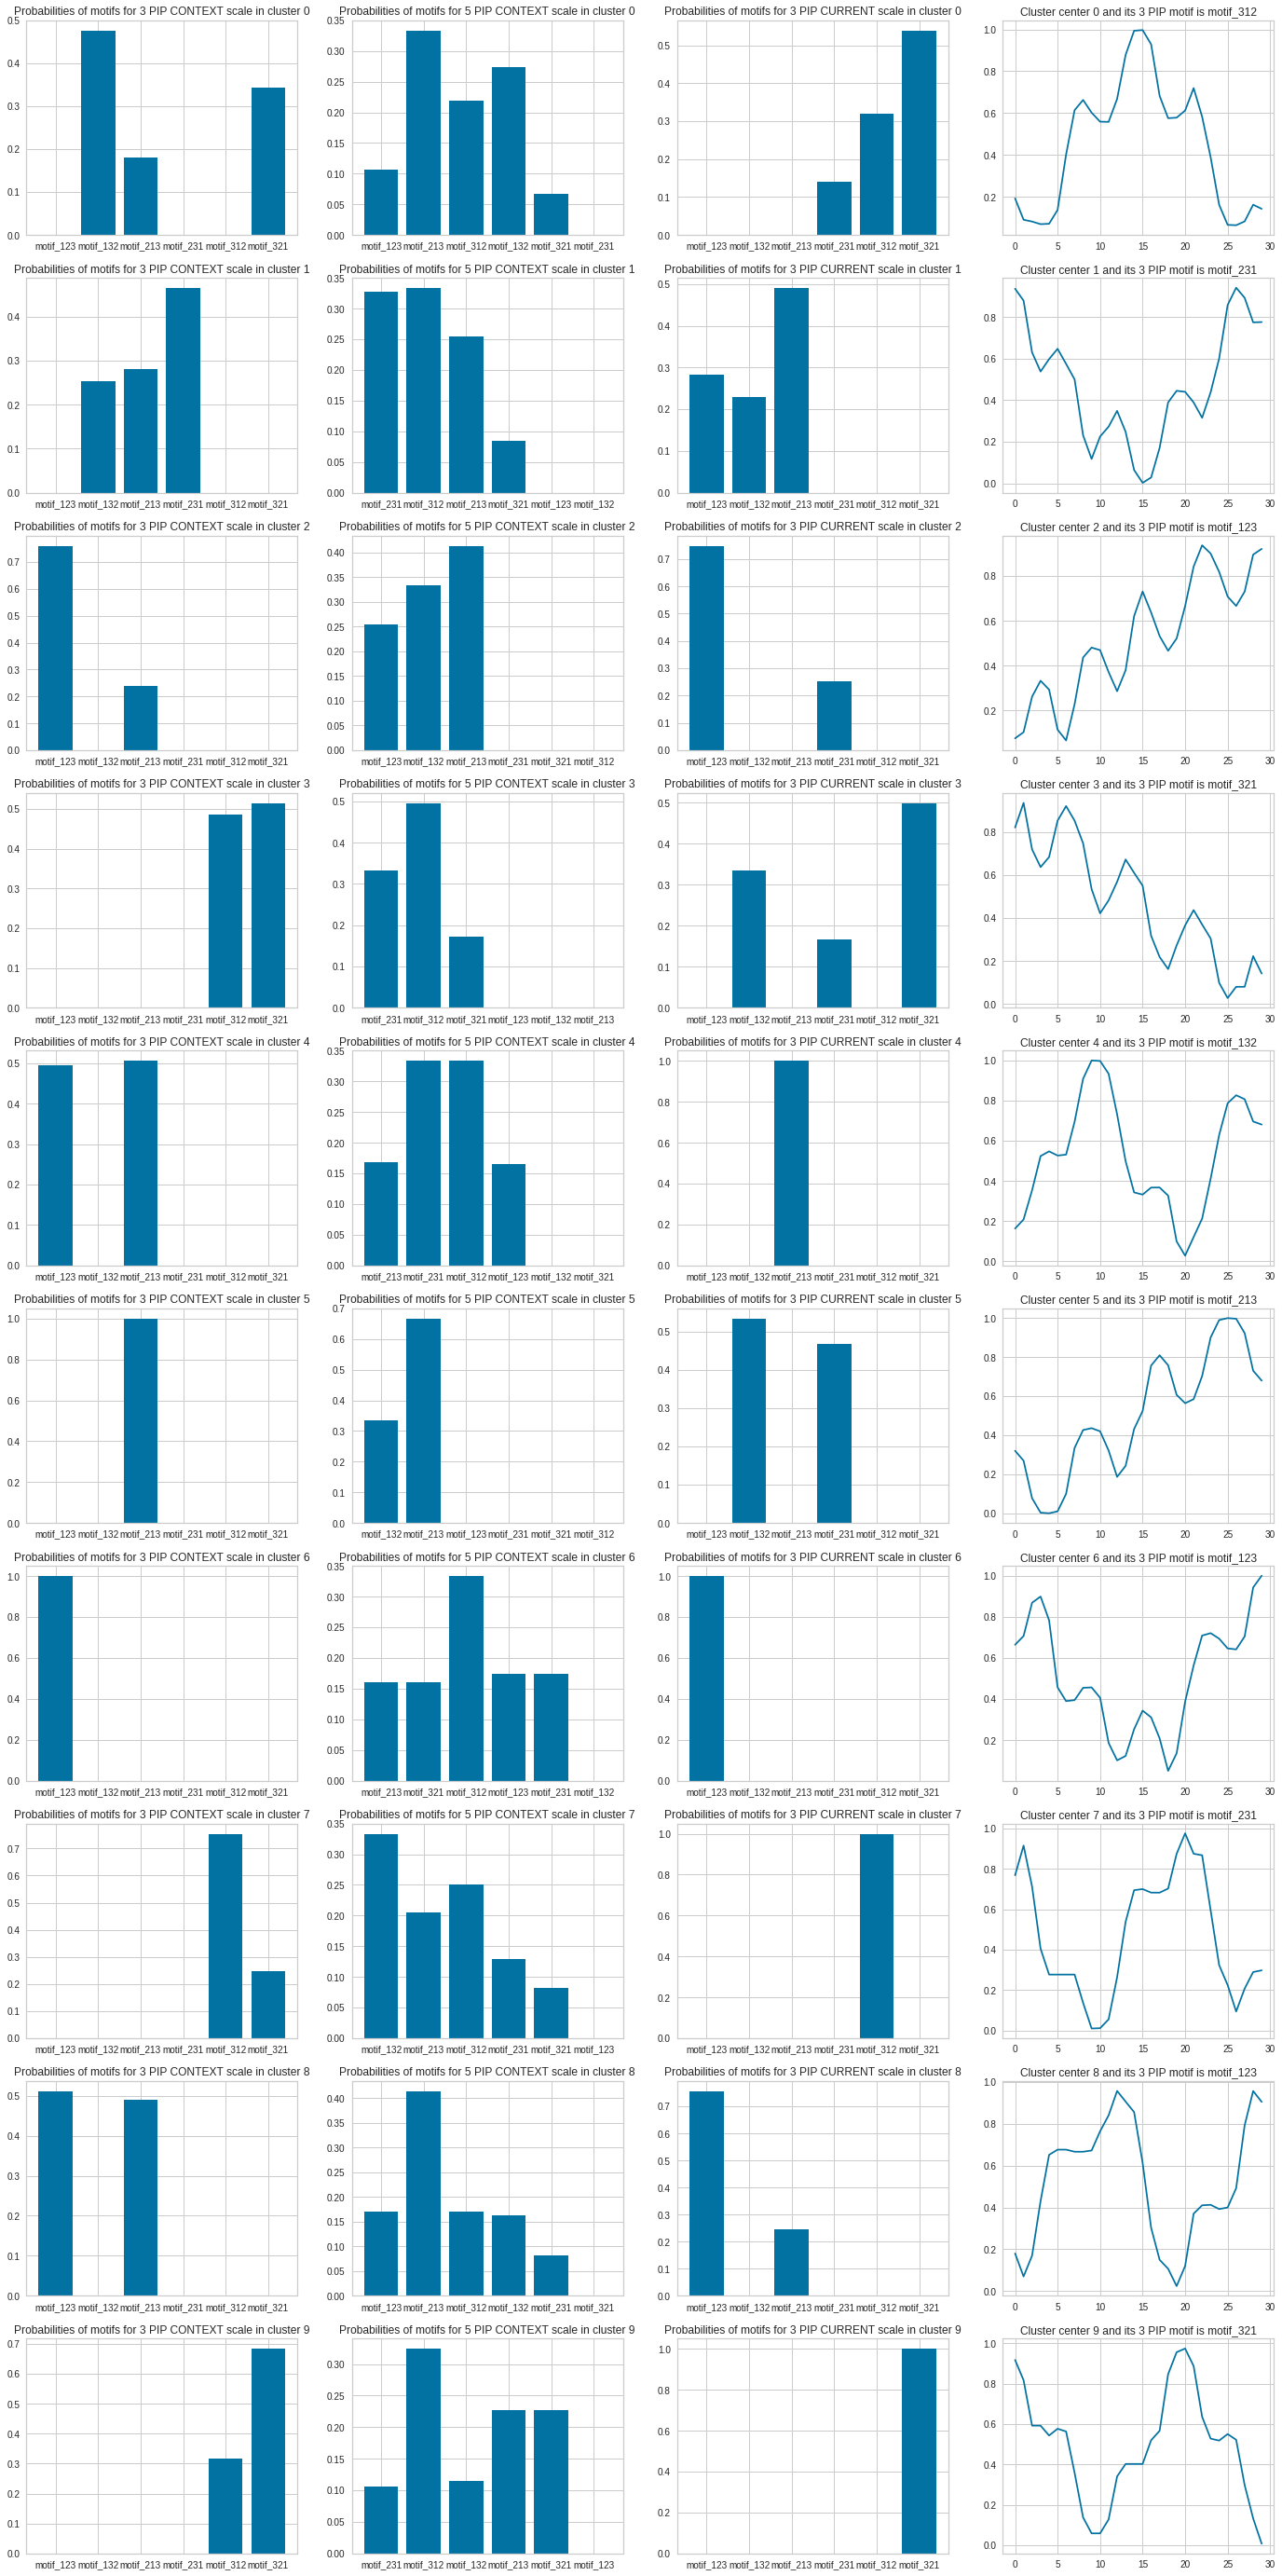

In [21]:
ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip_3 = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip_3 = reduce_dimension(current_matrix[indices],3)

  cluster_context_pip_5 = reduce_dimension(context_matrix[indices],5)

  context_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_context_pip_3).items()}
  current_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_current_pip_3).items()}
  context_motif_freq_5 = {k: v/sum(motif_dictionary(cluster_context_pip_5).values()) for k, v in motif_dictionary(cluster_context_pip_5).items()}

  ax[cluster,0].bar(list(context_motif_freq_3.keys()), list(context_motif_freq_3.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,2].bar(list(current_motif_freq_3.keys()), list(current_motif_freq_3.values()))
  ax[cluster,2].title.set_text('Probabilities of motifs for 3 PIP CURRENT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(context_motif_freq_5.keys()), list(context_motif_freq_5.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for 5 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,3].plot(context_center)
  ax[cluster,3].title.set_text('Cluster center '+str(cluster)+" and its 3 PIP motif is "+motif_cluster_center)


## KMedoids

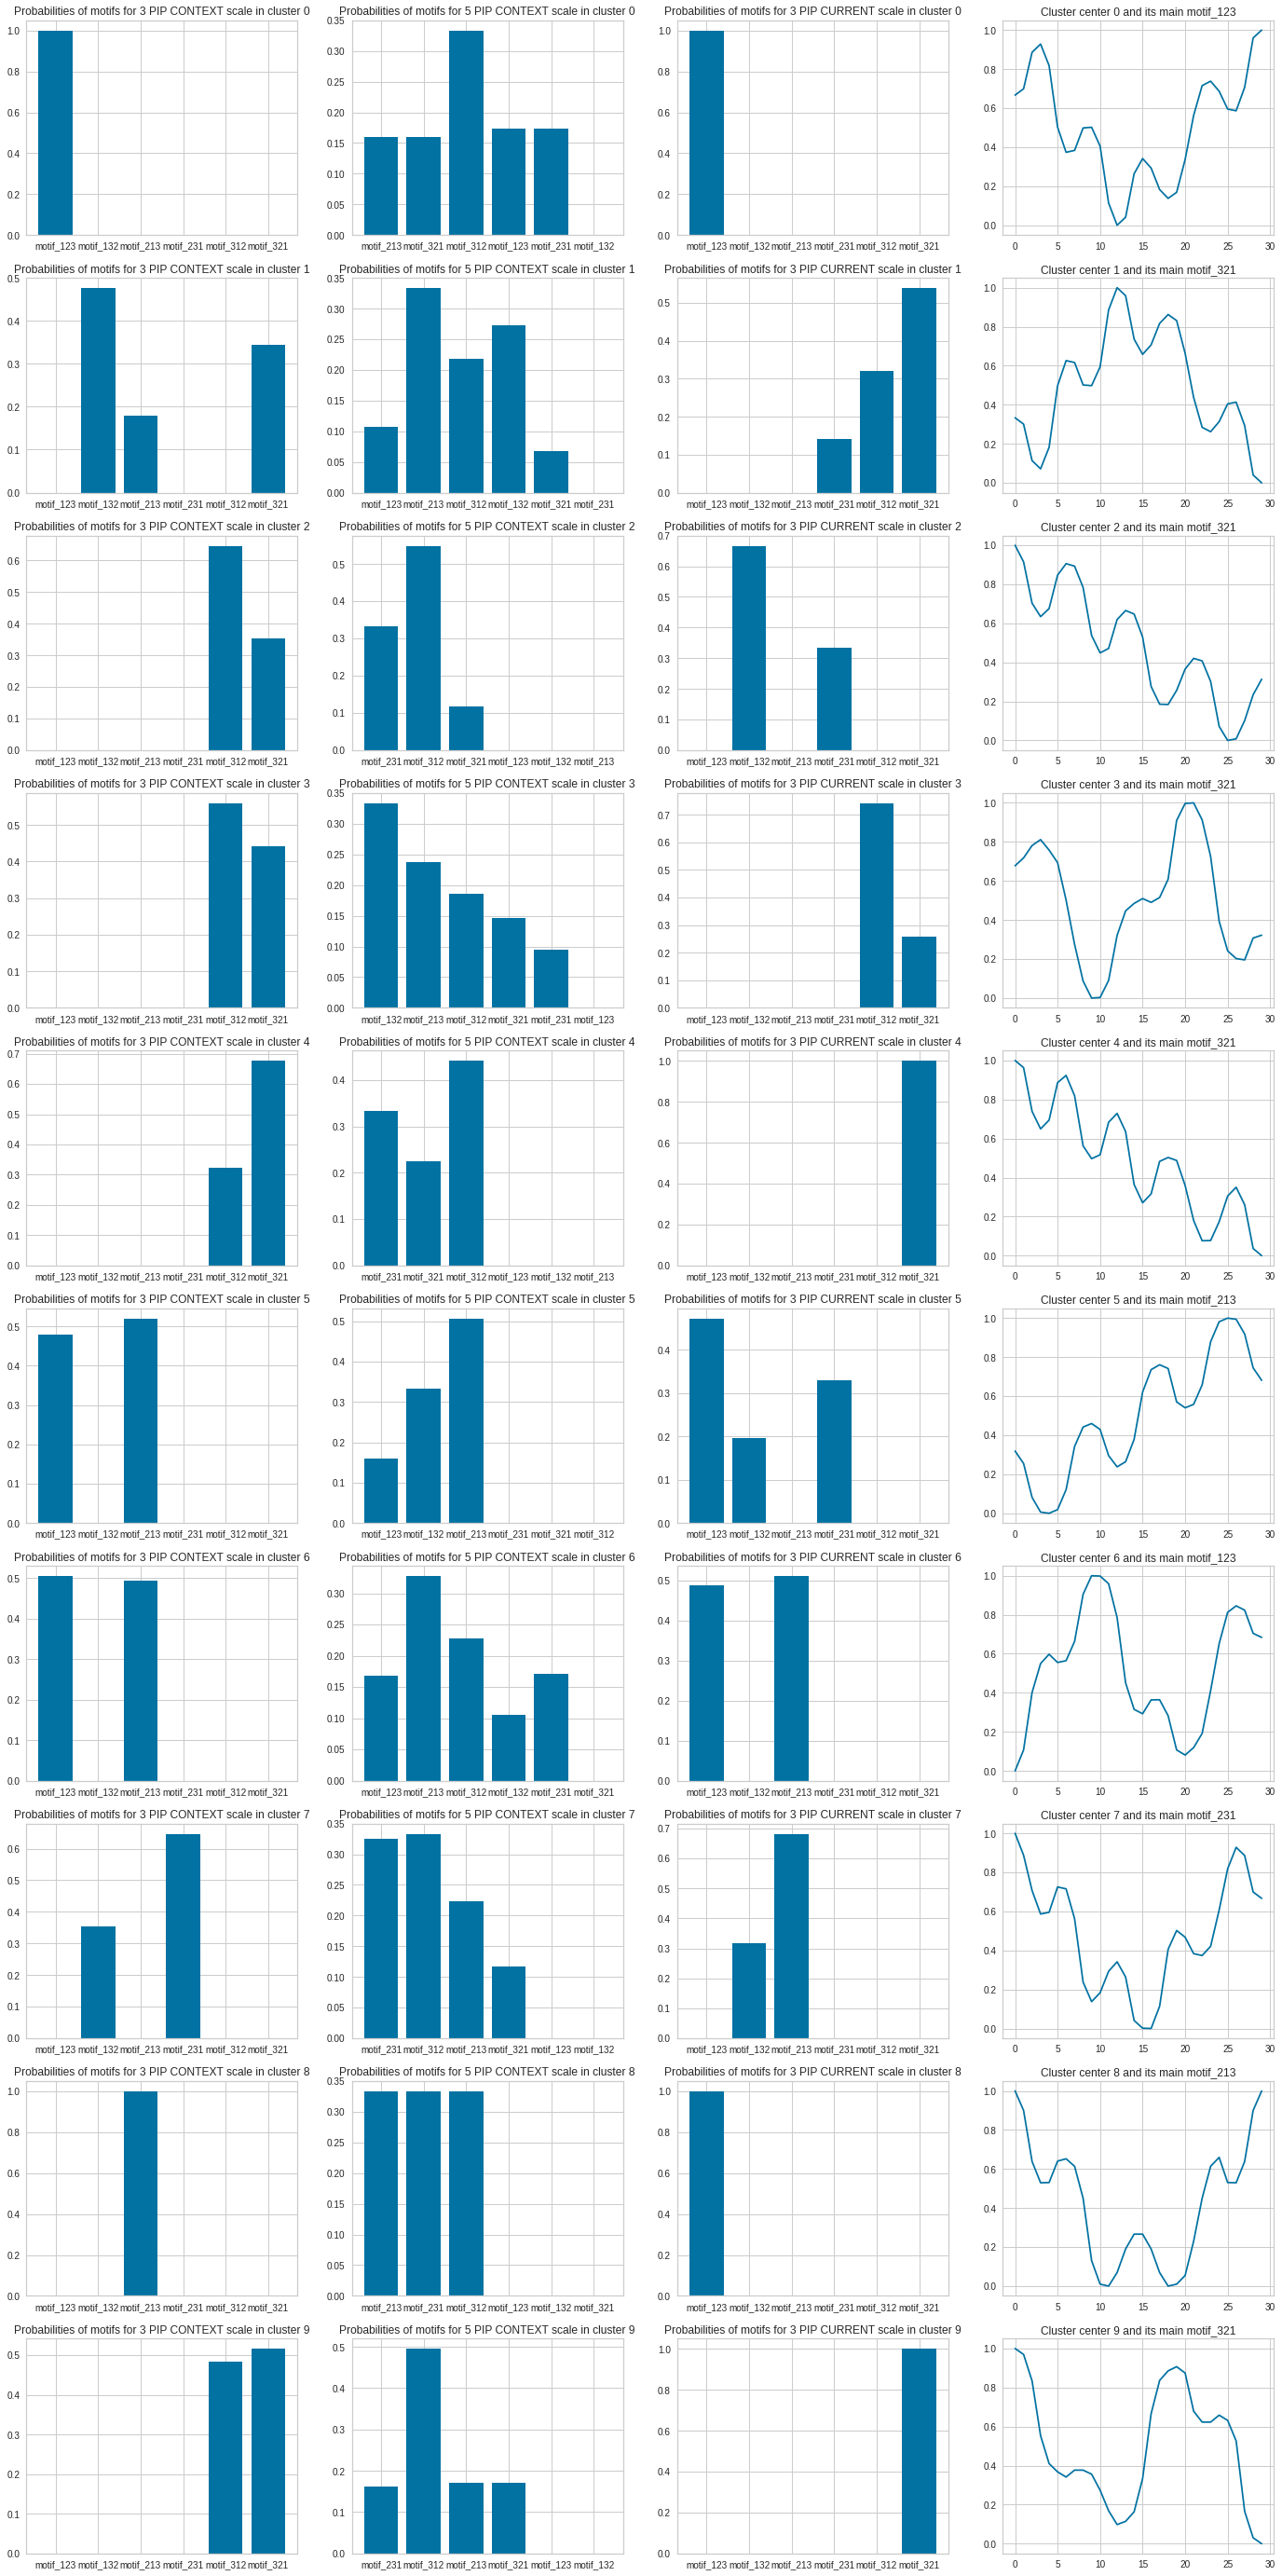

In [22]:
n_clusters = 10
model = KMedoids(n_clusters=n_clusters)
model.fit(context_pip)
y_train_pred = model.predict(context_pip)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip_3 = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip_3 = reduce_dimension(current_matrix[indices],3)

  cluster_context_pip_5 = reduce_dimension(context_matrix[indices],5)

  context_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_context_pip_3).items()}
  current_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_current_pip_3).items()}
  context_motif_freq_5 = {k: v/len(indices) for k, v in motif_dictionary(cluster_context_pip_5).items()}

  ax[cluster,0].bar(list(context_motif_freq_3.keys()), list(context_motif_freq_3.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,2].bar(list(current_motif_freq_3.keys()), list(current_motif_freq_3.values()))
  ax[cluster,2].title.set_text('Probabilities of motifs for 3 PIP CURRENT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(context_motif_freq_5.keys()), list(context_motif_freq_5.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for 5 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,3].plot(context_center)
  ax[cluster,3].title.set_text('Cluster center '+str(cluster)+" and its main "+motif_cluster_center)

# PIP PE on Real data

In [23]:
gen = TS_generator(nb_timeseries=1000, chunk_size=context_scale)
context_matrix = gen.get_array()
context_matrix_scale = np.transpose(MinMaxScaler().fit_transform(np.transpose(context_matrix.copy())))
context_matrix_pip = reduce_dimension(context_matrix_scale.copy(), 30)
context_matrix_smooth = DCT_lowpass_filter().fit_transform(context_matrix_pip.copy())

## KMeans with dtw

In [26]:
n_clusters = 6
model = TimeSeriesKMeans(n_clusters=n_clusters, metric = "dtw")
model.fit(context_matrix_smooth)
y_train_pred = model.predict(context_matrix_smooth)

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


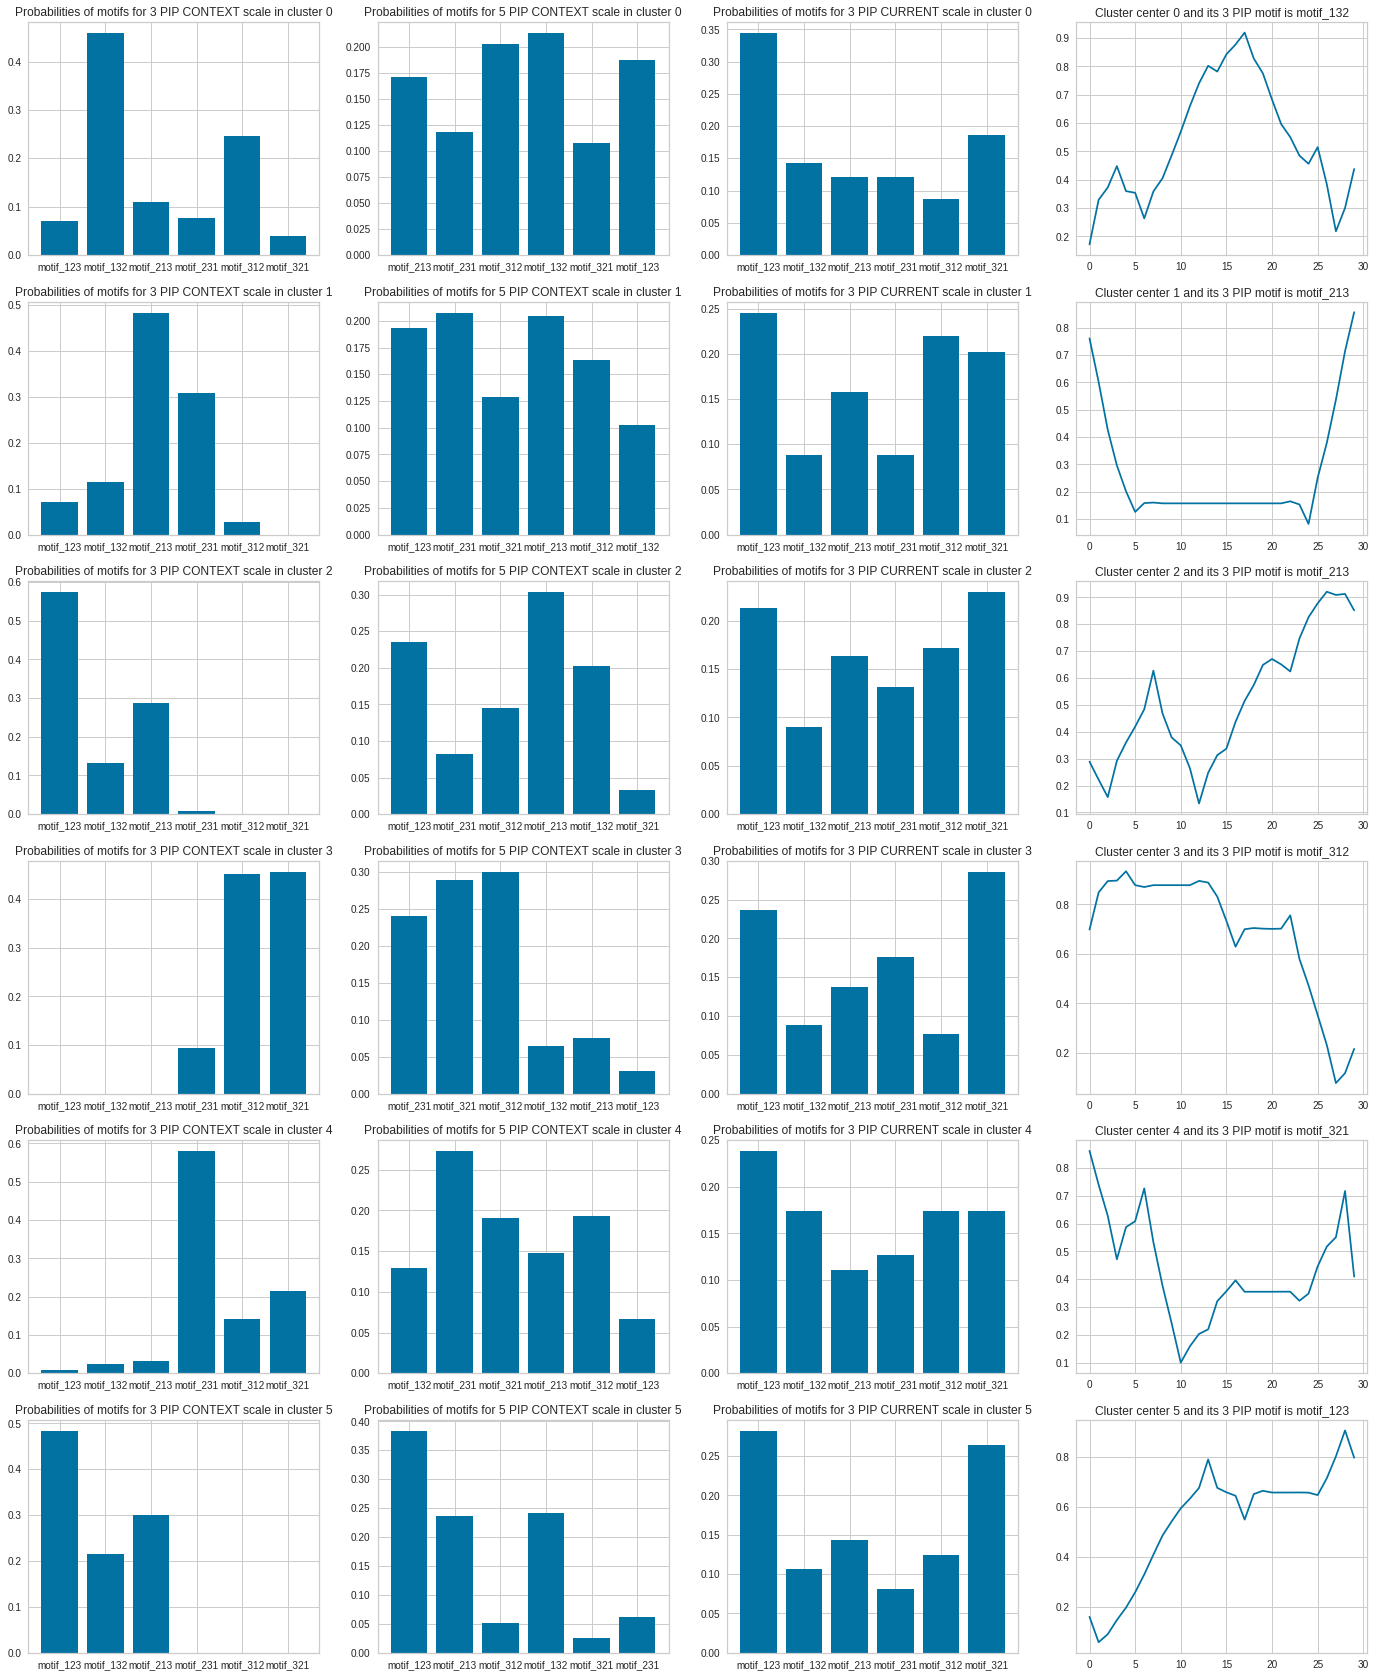

In [27]:
ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip_3 = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip_3 = reduce_dimension(current_matrix[indices],3)

  cluster_context_pip_5 = reduce_dimension(context_matrix[indices],5)

  context_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_context_pip_3).items()}
  current_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_current_pip_3).items()}
  context_motif_freq_5 = {k: v/sum(motif_dictionary(cluster_context_pip_5).values()) for k, v in motif_dictionary(cluster_context_pip_5).items()}

  ax[cluster,0].bar(list(context_motif_freq_3.keys()), list(context_motif_freq_3.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,2].bar(list(current_motif_freq_3.keys()), list(current_motif_freq_3.values()))
  ax[cluster,2].title.set_text('Probabilities of motifs for 3 PIP CURRENT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(context_motif_freq_5.keys()), list(context_motif_freq_5.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for 5 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,3].plot(context_center)
  ax[cluster,3].title.set_text('Cluster center '+str(cluster)+" and its 3 PIP motif is "+motif_cluster_center)


## KMedoids

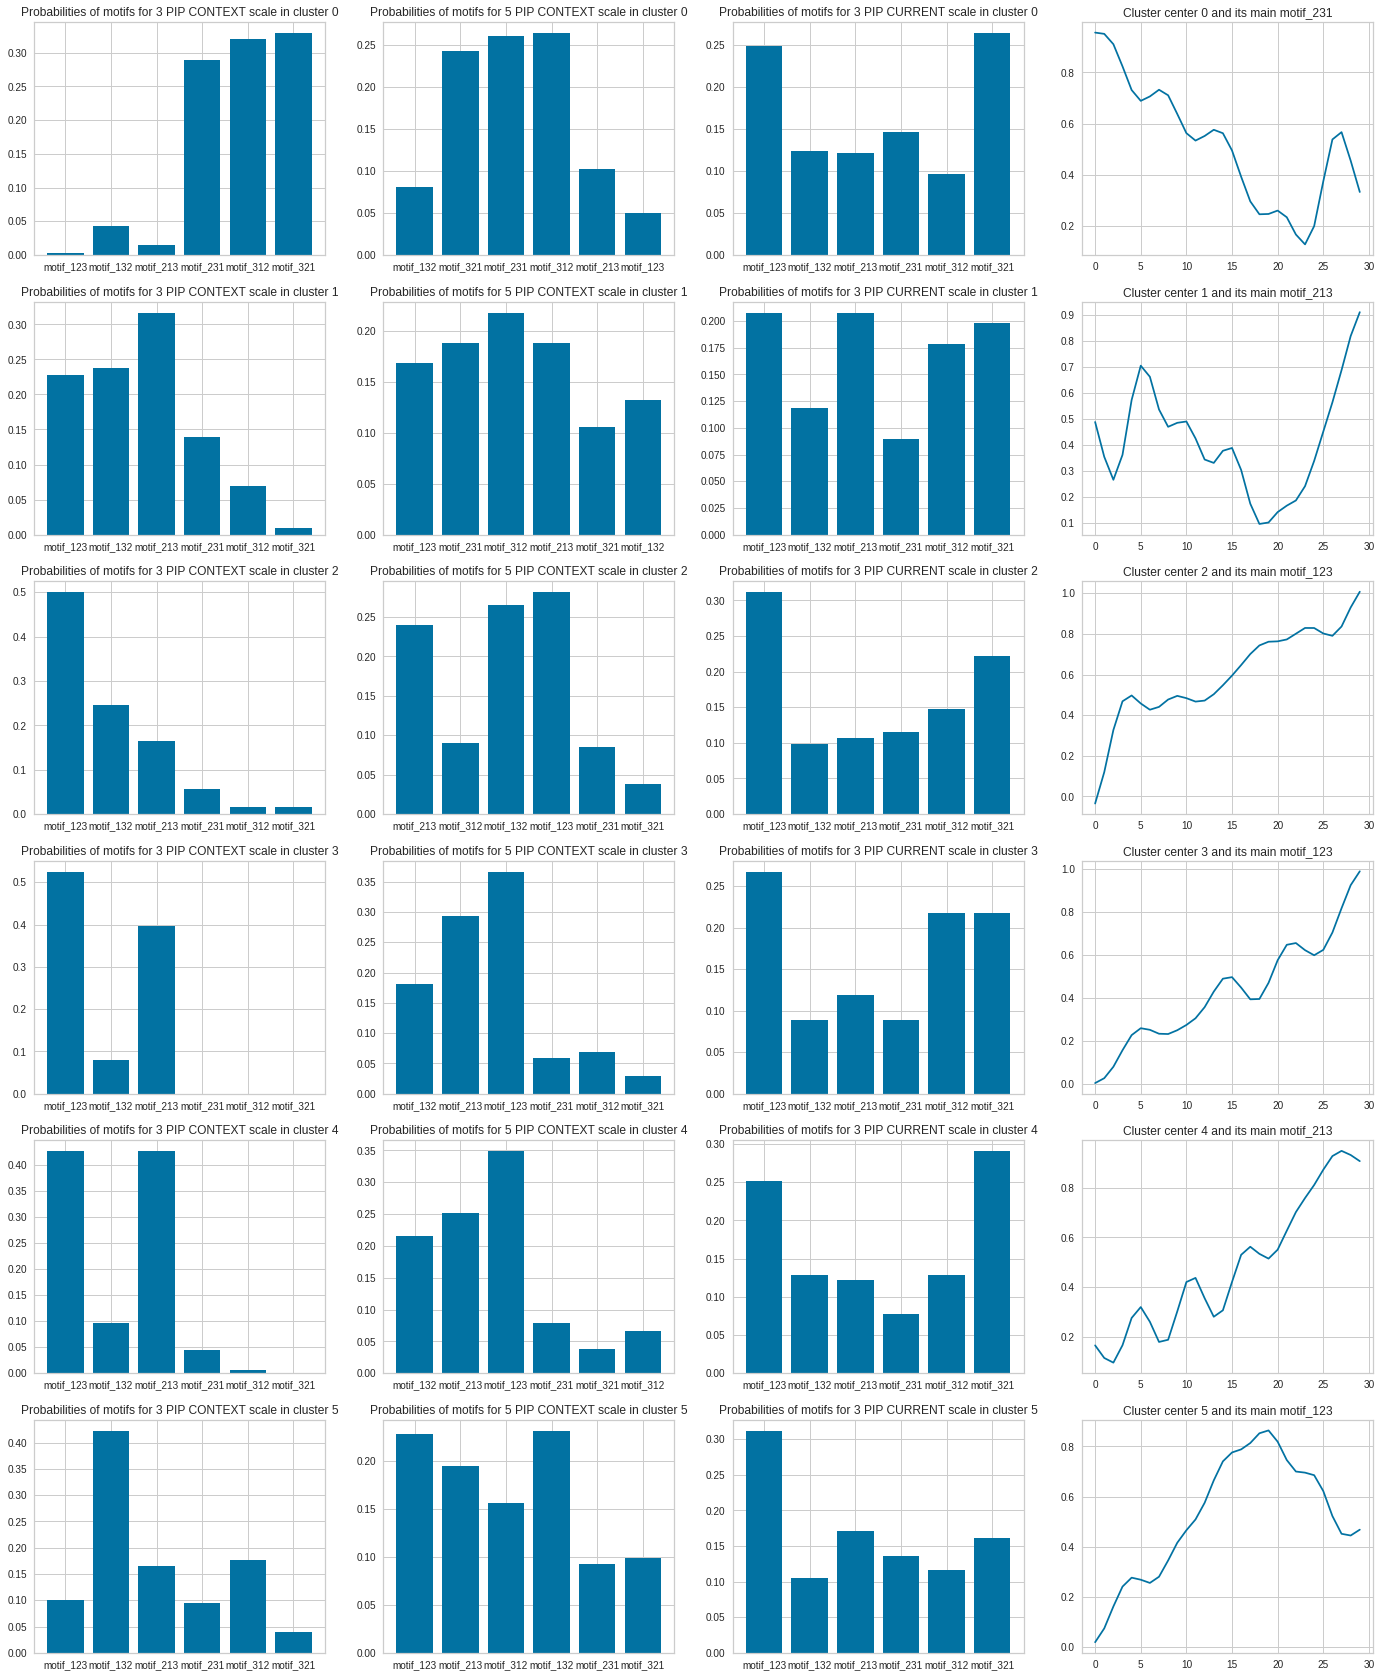

In [28]:
n_clusters = 6
model = KMedoids(n_clusters=n_clusters)
model.fit(context_matrix_smooth)
y_train_pred = model.predict(context_matrix_smooth)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip_3 = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip_3 = reduce_dimension(current_matrix[indices],3)

  cluster_context_pip_5 = reduce_dimension(context_matrix[indices],5)

  context_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_context_pip_3).items()}
  current_motif_freq_3 = {k: v/len(indices) for k, v in get_motif(cluster_current_pip_3).items()}
  context_motif_freq_5 = {k: v/len(indices) for k, v in motif_dictionary(cluster_context_pip_5).items()}

  ax[cluster,0].bar(list(context_motif_freq_3.keys()), list(context_motif_freq_3.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,2].bar(list(current_motif_freq_3.keys()), list(current_motif_freq_3.values()))
  ax[cluster,2].title.set_text('Probabilities of motifs for 3 PIP CURRENT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(context_motif_freq_5.keys()), list(context_motif_freq_5.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for 5 PIP CONTEXT scale in cluster '+str(cluster))
  ax[cluster,3].plot(context_center)
  ax[cluster,3].title.set_text('Cluster center '+str(cluster)+" and its main "+motif_cluster_center)
